# Assignment 7

## Support Vector Classifiers and Machines
Author: Samuel Fredric Berg

Student ID: sb224sc

Date: 2026-01-26

Course: Machine Learning 4DT905

### Conceptual

1. **SVMs** find the optimal separating hyperplane by maximizing the **margin** — the distance between the hyperplane and the nearest data points (support vectors) from each class. For linearly separable data, a hard-margin SVM finds the unique hyperplane with maximum margin. For overlapping classes, a soft-margin SVM introduces slack variables that allow some misclassifications, controlled by the cost parameter $C$. For non-linear boundaries, SVMs use the **kernel trick**: instead of explicitly mapping data to a high-dimensional feature space, a kernel function $K(x_i, x_j)$ computes inner products in that space efficiently, allowing the model to learn non-linear decision boundaries (e.g., radial/RBF, polynomial kernels).

2. SVMs are **not always robust** to overfitting and noisy data. The cost parameter $C$ and choice of kernel strongly affect robustness:
- **High $C$**: narrow margins, few violations allowed → model fits training data tightly, prone to overfitting noisy data.
- **Low $C$**: wide margins, more violations allowed → more regularization, less sensitive to noise.
- **Linear kernel**: relatively robust, fewer parameters, works well when decision boundary is approximately linear.
- **RBF/polynomial kernels**: flexible, can overfit with wrong hyperparameters ($\gamma$, degree); high $\gamma$ leads to overly complex boundaries that memorize noise.
- In high-noise settings, careful cross-validation to tune $C$ (and $\gamma$) is essential for good generalization.

### Practical

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### Step 1: Generate data and get an overview

In [2]:
np.random.seed(1)
X = np.random.randn(20, 2)
y = np.array([-1]*10 + [1]*10)
X[y == 1] += 1

print("X:")
print(X)
print("\ny:", y)

X:
[[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071]
 [-0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127]
 [-0.17242821 -0.87785842]
 [ 0.04221375  0.58281521]
 [-0.10061918  2.14472371]
 [ 1.90159072  1.50249434]
 [ 1.90085595  0.31627214]
 [ 0.87710977  0.06423057]
 [ 0.73211192  1.53035547]
 [ 0.30833925  0.60324647]
 [ 0.3128273   0.15479436]
 [ 0.32875387  0.9873354 ]
 [-0.11731035  1.2344157 ]
 [ 2.65980218  1.74204416]]

y: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1]


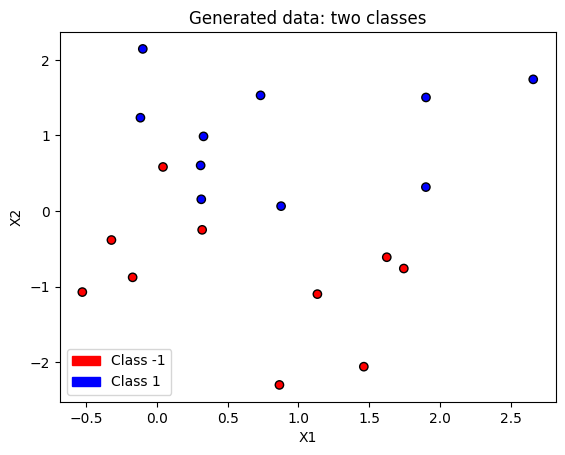

The classes are not linearly separable.


In [3]:
colors = np.where(y == 1, 'blue', 'red')
plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')
plt.title('Generated data: two classes')
plt.xlabel('X1')
plt.ylabel('X2')
red_patch = mpatches.Patch(color='red', label='Class -1')
blue_patch = mpatches.Patch(color='blue', label='Class 1')
plt.legend(handles=[red_patch, blue_patch])
plt.show()
print('The classes are not linearly separable.')

#### Step 2: Learn and assess a support vector (soft margin) classifier

Fit the support vector classifier with `kernel='linear'` and `C=10` (scale=False, i.e., no feature normalization).

In [4]:
svc = SVC(kernel='linear', C=10)
svc.fit(X, y)
print('Number of support vectors per class:', svc.n_support_)
print('Support vector indices:', svc.support_)

Number of support vectors per class: [3 3]
Support vector indices: [ 0  4  9 13 15 16]


In [5]:
def plot_svc(clf, X, y, title='SVC Decision Boundary'):
    """Plot the SVM decision boundary and margins."""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)
    colors = np.where(y == 1, 'blue', 'red')
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k', zorder=3)
    # Mark support vectors
    plt.scatter(X[clf.support_, 0], X[clf.support_, 1],
                s=200, facecolors='none', edgecolors='k', linewidths=2,
                zorder=4, label='Support vectors')
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.show()

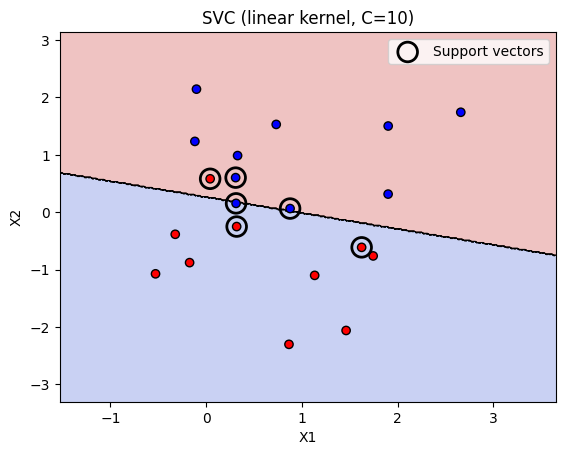

Number of support vectors: 6


In [6]:
plot_svc(svc, X, y, title='SVC (linear kernel, C=10)')
print(f'Number of support vectors: {sum(svc.n_support_)}')

**Interpretation:** With `C=10` (high cost), the margin is narrow and only a few observations become support vectors. The classifier penalizes misclassifications heavily, resulting in a tight decision boundary — low bias but potentially higher variance.

What if we use a smaller cost parameter?

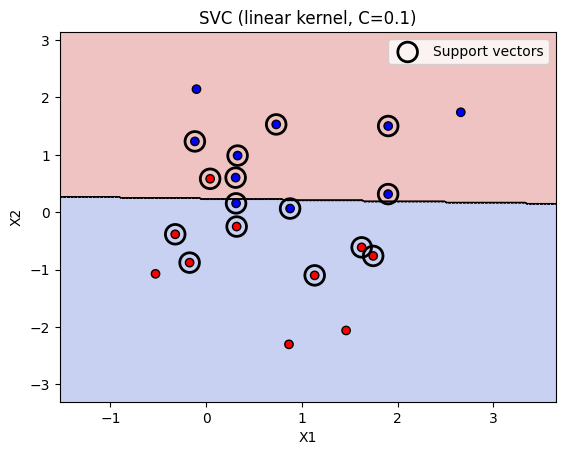

Number of support vectors: 15
Support vector indices: [ 0  3  4  6  7  8  9 11 12 13 14 15 16 17 18]


In [7]:
svc_small = SVC(kernel='linear', C=0.1)
svc_small.fit(X, y)
plot_svc(svc_small, X, y, title='SVC (linear kernel, C=0.1)')
print(f'Number of support vectors: {sum(svc_small.n_support_)}')
print('Support vector indices:', svc_small.support_)

**Interpretation (variance-bias tradeoff):** With `C=0.1` (low cost), the margin is wider and more observations become support vectors, including some that violate the margin. The model allows more misclassifications on training data (higher bias) but is more regularized and likely to generalize better (lower variance). The decision boundary is less sensitive to individual data points.

**Cross-validation to determine the cost parameter**

In [8]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}
cv_svc = GridSearchCV(SVC(kernel='linear'), param_grid, cv=10, scoring='accuracy')
cv_svc.fit(X, y)

print('Cross-validation results:')
results = cv_svc.cv_results_
for mean, std, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print(f"  C={params['C']:.3f}  accuracy={mean:.4f}  error={1-mean:.4f}  std={std:.4f}")
print(f"\nBest parameters: {cv_svc.best_params_}")
print(f"Best CV accuracy: {cv_svc.best_score_:.4f}  (error: {1-cv_svc.best_score_:.4f})")

Cross-validation results:
  C=0.001  accuracy=0.9500  error=0.0500  std=0.1500
  C=0.010  accuracy=0.9500  error=0.0500  std=0.1500
  C=0.100  accuracy=0.8500  error=0.1500  std=0.2291
  C=1.000  accuracy=0.9000  error=0.1000  std=0.2000
  C=5.000  accuracy=0.9000  error=0.1000  std=0.2000
  C=10.000  accuracy=0.9000  error=0.1000  std=0.2000
  C=100.000  accuracy=0.9000  error=0.1000  std=0.2000

Best parameters: {'C': 0.001}
Best CV accuracy: 0.9500  (error: 0.0500)


**Interpretation:** Cross-validation selects the `C` that minimizes the test error. A moderate `C` typically performs best, balancing margin width against misclassifications on the training set.

In [9]:
best_svc = cv_svc.best_estimator_
print('Best model summary:')
print(f'  Kernel: {best_svc.kernel}')
print(f'  C: {best_svc.C}')
print(f'  Number of support vectors: {sum(best_svc.n_support_)}')

Best model summary:
  Kernel: linear
  C: 0.001
  Number of support vectors: 20


**Generate test data and predict**

In [10]:
np.random.seed(2)
X_test = np.random.randn(20, 2)
y_test = np.random.choice([-1, 1], size=20, replace=True)
X_test[y_test == 1] += 1

y_pred = best_svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])
print('Confusion matrix (rows=true, cols=predicted):')
print(pd.DataFrame(cm, index=['true -1', 'true 1'], columns=['pred -1', 'pred 1']))
print(f'\nTest accuracy: {(y_pred == y_test).mean():.4f}')

Confusion matrix (rows=true, cols=predicted):
         pred -1  pred 1
true -1       11       5
true 1         1       3

Test accuracy: 0.7000


**Interpretation:** The best model (selected via cross-validation) correctly classifies most test observations. Some misclassifications are expected since the classes are not perfectly linearly separable.

#### Step 3: Learn and assess an SVM classifier (radial kernel)

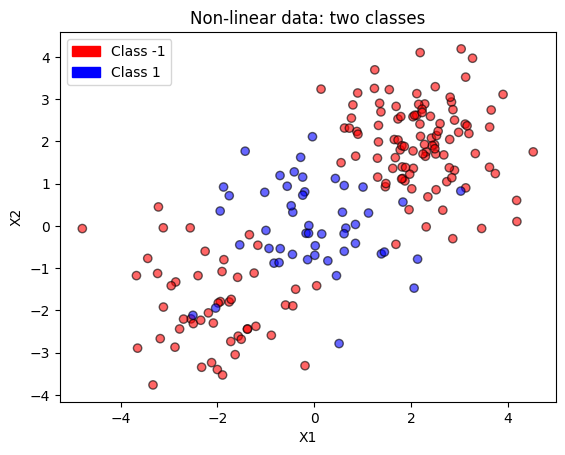

In [11]:
np.random.seed(1)
X2 = np.random.randn(200, 2)
X2[:100] += 2
X2[100:150] -= 2
y2 = np.array([-1]*150 + [1]*50)

colors2 = np.where(y2 == 1, 'blue', 'red')
plt.scatter(X2[:, 0], X2[:, 1], c=colors2, edgecolors='k', alpha=0.6)
plt.title('Non-linear data: two classes')
plt.xlabel('X1')
plt.ylabel('X2')
red_patch = mpatches.Patch(color='red', label='Class -1')
blue_patch = mpatches.Patch(color='blue', label='Class 1')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

In [12]:
np.random.seed(1)
train_idx = np.random.choice(200, 100, replace=False)
test_idx = np.setdiff1d(np.arange(200), train_idx)
X2_train, y2_train = X2[train_idx], y2[train_idx]
X2_test, y2_test = X2[test_idx], y2[test_idx]

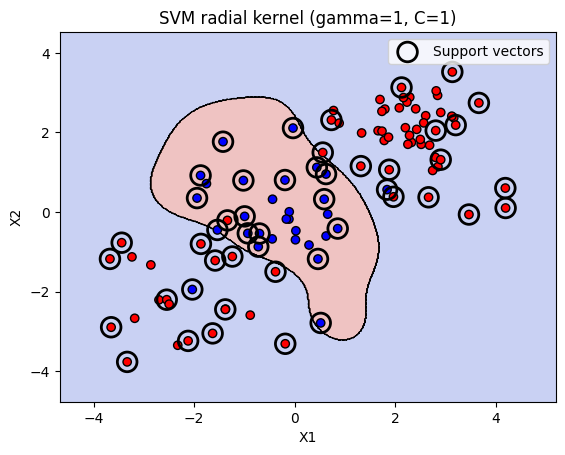

Training accuracy: 0.9700  (Training error: 0.0300)


In [13]:
svm_radial = SVC(kernel='rbf', gamma=1, C=1)
svm_radial.fit(X2_train, y2_train)
plot_svc(svm_radial, X2_train, y2_train, title='SVM radial kernel (gamma=1, C=1)')
train_acc = svm_radial.score(X2_train, y2_train)
print(f'Training accuracy: {train_acc:.4f}  (Training error: {1-train_acc:.4f})')

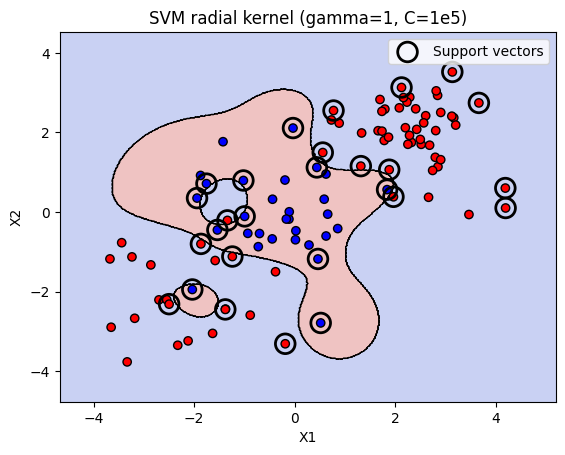

Training accuracy: 1.0000  (Training error: 0.0000)
High C reduces training errors but may overfit.


In [14]:
svm_radial_hc = SVC(kernel='rbf', gamma=1, C=1e5)
svm_radial_hc.fit(X2_train, y2_train)
plot_svc(svm_radial_hc, X2_train, y2_train, title='SVM radial kernel (gamma=1, C=1e5)')
train_acc_hc = svm_radial_hc.score(X2_train, y2_train)
print(f'Training accuracy: {train_acc_hc:.4f}  (Training error: {1-train_acc_hc:.4f})')
print('High C reduces training errors but may overfit.')

In [15]:
param_grid2 = {'C': [0.1, 1, 10, 100, 1000],
               'gamma': [0.5, 1, 2, 3, 4]}
cv_svm = GridSearchCV(SVC(kernel='rbf'), param_grid2, cv=10, scoring='accuracy')
cv_svm.fit(X2_train, y2_train)

print('Best parameters:', cv_svm.best_params_)
print(f'Best CV accuracy: {cv_svm.best_score_:.4f}  (error: {1-cv_svm.best_score_:.4f})')

Best parameters: {'C': 1, 'gamma': 2}
Best CV accuracy: 0.9200  (error: 0.0800)


In [16]:
y2_pred = cv_svm.best_estimator_.predict(X2_test)
cm2 = confusion_matrix(y2_test, y2_pred, labels=[-1, 1])
print('Confusion matrix (rows=true, cols=predicted):')
print(pd.DataFrame(cm2, index=['true -1', 'true 1'], columns=['pred -1', 'pred 1']))
print(f'\nTest accuracy: {(y2_pred == y2_test).mean():.4f}')

Confusion matrix (rows=true, cols=predicted):
         pred -1  pred 1
true -1       79       1
true 1         5      15

Test accuracy: 0.9400


**Interpretation:** The radial (RBF) kernel handles the non-linear class boundary well. Cross-validation selects the best `C` and `gamma` combination. The test set confusion matrix shows the model generalizes, though some misclassifications are expected in regions where classes overlap.

#### Step 4: Learn and assess an SVM classifier for multiple classes

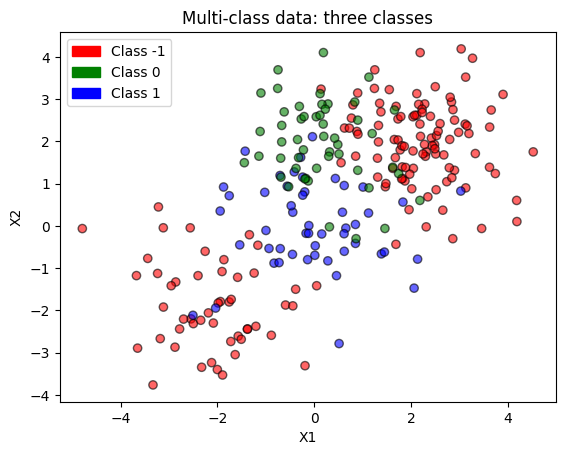

In [17]:
np.random.seed(1)
X3_extra = np.random.randn(50, 2)
X3 = np.vstack([X2, X3_extra])
y3 = np.concatenate([y2, np.zeros(50, dtype=int)])
X3[y3 == 0, 1] += 2

colors3 = {-1: 'red', 0: 'green', 1: 'blue'}
c3 = [colors3[cl] for cl in y3]
plt.scatter(X3[:, 0], X3[:, 1], c=c3, edgecolors='k', alpha=0.6)
plt.title('Multi-class data: three classes')
plt.xlabel('X1')
plt.ylabel('X2')
patches = [mpatches.Patch(color=v, label=f'Class {k}') for k, v in colors3.items()]
plt.legend(handles=patches)
plt.show()

In [18]:
np.random.seed(1)
train_idx3 = np.random.choice(250, 125, replace=False)
test_idx3 = np.setdiff1d(np.arange(250), train_idx3)
X3_train, y3_train = X3[train_idx3], y3[train_idx3]
X3_test, y3_test = X3[test_idx3], y3[test_idx3]

In [19]:
svm_multi = SVC(kernel='rbf', C=10, gamma=1)
svm_multi.fit(X3_train, y3_train)
print('Number of support vectors per class:', svm_multi.n_support_)
print('Classes:', svm_multi.classes_)

Number of support vectors per class: [30 17 15]
Classes: [-1  0  1]


In [20]:
param_grid3 = {'C': [0.1, 1, 10, 100, 1000],
               'gamma': [0.5, 1, 2, 3, 4]}
cv_svm3 = GridSearchCV(SVC(kernel='rbf'), param_grid3, cv=10, scoring='accuracy')
cv_svm3.fit(X3_train, y3_train)
print('Best parameters:', cv_svm3.best_params_)
print(f'Best CV accuracy: {cv_svm3.best_score_:.4f}  (error: {1-cv_svm3.best_score_:.4f})')

Best parameters: {'C': 1, 'gamma': 3}
Best CV accuracy: 0.8571  (error: 0.1429)


In [21]:
y3_pred = cv_svm3.best_estimator_.predict(X3_test)
classes = sorted(set(y3_test))
cm3 = confusion_matrix(y3_test, y3_pred, labels=classes)
print('Confusion matrix (rows=true, cols=predicted):')
labels = [f'class {c}' for c in classes]
print(pd.DataFrame(cm3, index=[f'true {c}' for c in classes], columns=[f'pred {c}' for c in classes]))
print(f'\nTest accuracy: {(y3_pred == y3_test).mean():.4f}')

Confusion matrix (rows=true, cols=predicted):
         pred -1  pred 0  pred 1
true -1       77       0       0
true 0         8      13       2
true 1         8       5      12

Test accuracy: 0.8160


**Interpretation:** sklearn's `SVC` uses a one-vs-one strategy for multi-class classification. Cross-validation selects the best parameters. The confusion matrix shows performance across all three classes, with the dominant class (-1) often being predicted most accurately due to more training examples.

#### Step 5: Apply SVM to Gene Expression Data (Khan dataset)

In [22]:
X_train_khan = pd.read_csv('../data/Khan_xtrain.csv', index_col=0)
X_test_khan = pd.read_csv('../data/Khan_xtest.csv', index_col=0)
y_train_khan = pd.read_csv('../data/Khan_ytrain.csv', index_col=0).squeeze()
y_test_khan = pd.read_csv('../data/Khan_ytest.csv', index_col=0).squeeze()

print('Training set dimensions:', X_train_khan.shape)
print('Test set dimensions:', X_test_khan.shape)
print('Training labels:', sorted(y_train_khan.unique()))
print('Training label counts:')
print(y_train_khan.value_counts().sort_index())

Training set dimensions: (63, 2308)
Test set dimensions: (20, 2308)
Training labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
Training label counts:
x
1     8
2    23
3    12
4    20
Name: count, dtype: int64


The Khan dataset has 2308 gene expression features and only 63 training observations. Because the number of features vastly exceeds the number of observations, a **linear kernel** is appropriate — additional flexibility from polynomial or radial kernels is unnecessary and can lead to overfitting.

In [23]:
svm_khan = SVC(kernel='linear', C=10)
svm_khan.fit(X_train_khan, y_train_khan)
print('SVM fitted:')
print(f'  Kernel: {svm_khan.kernel}')
print(f'  C: {svm_khan.C}')
print(f'  Classes: {svm_khan.classes_}')
print(f'  Support vectors per class: {svm_khan.n_support_}')

SVM fitted:
  Kernel: linear
  C: 10
  Classes: [1 2 3 4]
  Support vectors per class: [ 7 18  9 20]


In [24]:
y_train_pred = svm_khan.predict(X_train_khan)
cm_train = confusion_matrix(y_train_khan, y_train_pred, labels=sorted(y_train_khan.unique()))
classes_k = sorted(y_train_khan.unique())
print('Training confusion matrix:')
print(pd.DataFrame(cm_train,
                   index=[f'true {c}' for c in classes_k],
                   columns=[f'pred {c}' for c in classes_k]))
print(f'\nTraining error: {1 - (y_train_pred == y_train_khan).mean():.4f}')
print('There are no training errors, as expected when features >> observations.')

Training confusion matrix:
        pred 1  pred 2  pred 3  pred 4
true 1       8       0       0       0
true 2       0      23       0       0
true 3       0       0      12       0
true 4       0       0       0      20

Training error: 0.0000
There are no training errors, as expected when features >> observations.


In [25]:
y_test_pred = svm_khan.predict(X_test_khan)
cm_test = confusion_matrix(y_test_khan, y_test_pred, labels=classes_k)
print('Test confusion matrix:')
print(pd.DataFrame(cm_test,
                   index=[f'true {c}' for c in classes_k],
                   columns=[f'pred {c}' for c in classes_k]))
print(f'\nTest error: {1 - (y_test_pred == y_test_khan).mean():.4f}')

Test confusion matrix:
        pred 1  pred 2  pred 3  pred 4
true 1       3       0       0       0
true 2       0       6       0       0
true 3       0       2       4       0
true 4       0       0       0       5

Test error: 0.1000


**Interpretation:** As expected with a large number of features relative to observations, the linear SVM achieves zero training error — it is easy to find a hyperplane perfectly separating the classes in high-dimensional space. On the test set, the SVM generalizes well (few misclassifications), demonstrating that gene expression patterns are informative for distinguishing the 4 cancer subtypes.